
`prediction_visualization_final.png` 파일이 저장되었습니다.


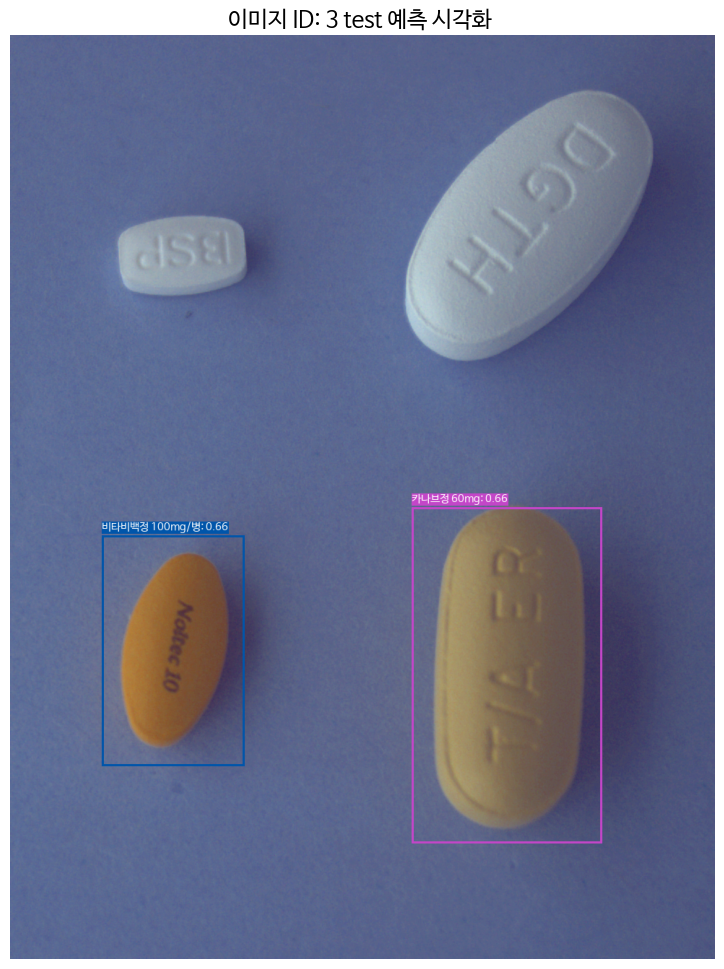

In [ ]:
# import pandas as pd
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from typing import Dict, List
# from PIL import ImageFont, ImageDraw, Image
# import os

# # Matplotlib의 폰트 패밀리 설정
# plt.rc("font", family="NanumBarunGothic")
# # 폰트 파일의 실제 경로를 찾아서 지정합니다. (Pillow에서 사용)
# # 보통 이 경로에 있습니다. 만약 다르다면 find / -name "NanumBarunGothic.ttf" 명령어로 찾으세요.
# FONT_PATH = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"

# # 폰트 파일이 있는지 확인
# if not os.path.exists(FONT_PATH):
#     print(f"⚠️ 폰트 파일을 찾을 수 없습니다: {FONT_PATH}")
#     print(
#         "Pillow를 사용한 한글 표기가 불가능합니다. 시스템에 맞는 폰트 경로를 확인해주세요."
#     )
#     # 대체 경로 (macOS의 경우)
#     # FONT_PATH = "/Library/Fonts/NanumBarunGothic.ttf"
#     FONT_PATH = None  # 폰트가 없으면 None으로 설정
# # ==============================================================================


# # # 데이터 로드
# # train_meta_df = pd.read_csv("../data/processed/train_annotations_cleaned.csv")
# # # 예측 결과 파일
# # submission_df = pd.read_csv("../output/submission_250730_BASELINE_cleaned.csv")
# # TEST_META_PATH = "../data/processed/test.csv"
# # test_meta_df = pd.read_csv(TEST_META_PATH)

# # 클래스 맵 생성
# class_map = (
#     train_meta_df[["category_id", "class_name"]]
#     .drop_duplicates()
#     .set_index("category_id")["class_name"]
#     .to_dict()
# )

# # 시각화할 이미지 ID 선택
# TARGET_IMAGE_ID = 3
# preds_for_image = submission_df[submission_df["image_id"] == TARGET_IMAGE_ID]

# # 이미지 경로 매칭 및 로드
# try:
#     image_info = test_meta_df[test_meta_df["image_id"] == TARGET_IMAGE_ID].iloc[0]
#     TEST_IMAGE_BASE_PATH = (
#         "../data/raw/ai03-level1-project/test_images"  # 실제 test 이미지 폴더 경로
#     )
#     image_path = f"{TEST_IMAGE_BASE_PATH}/{image_info['file_name']}"
#     image = cv2.imread(image_path)
#     if image is None:
#         raise FileNotFoundError
# except (FileNotFoundError, IndexError):
#     print(
#         f"이미지 ID {TARGET_IMAGE_ID}의 파일을 찾을 수 없습니다. 더미 이미지를 사용합니다."
#     )
#     image = np.zeros((960, 1280, 3), dtype=np.uint8)  # 더미 이미지 생성


# # ✨ 최종 시각화 함수 호출
# if FONT_PATH:  # 폰트 경로가 제대로 설정되었을 때만 실행
#     image_result = visualize_predictions_final(
#         image=image,
#         preds_df=preds_for_image,
#         class_name_map=class_map,
#         font_path=FONT_PATH,  # 폰트 경로를 직접 전달
#         threshold=0.5,
#     )

#     # Matplotlib으로 결과 이미지 표시
#     plt.figure(figsize=(12, 12))
#     plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))
#     plt.title(f"이미지 ID: {TARGET_IMAGE_ID} test 예측 시각화 ", fontsize=16)
#     plt.axis("off")
#     plt.savefig("prediction_visualization_final.png", dpi=300, bbox_inches="tight")
#     print("\n`prediction_visualization_final.png` 파일이 저장되었습니다.")
# else:
#     print("\n폰트가 설정되지 않아 시각화 이미지를 생성하지 않았습니다.")

In [1]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Dict, List
from PIL import ImageFont, ImageDraw, Image
import os


def visualize_predictions_final(
    image: np.ndarray,
    preds_df: pd.DataFrame,
    class_name_map: Dict[int, str],
    font_path: str,
    threshold: float = 0.5,
) -> np.ndarray:
    """
    Pillow를 사용하여 이미지 위에 한글을 포함한 예측 결과를 시각화합니다.
    """
    image_with_boxes = image.copy()

    # Pillow에서 사용할 수 있도록 OpenCV(BGR) 이미지를 RGB로 변환하고 Pillow 이미지 객체로 만듭니다.
    img_pil = Image.fromarray(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)

    try:
        font = ImageFont.truetype(font_path, 15)  # 폰트와 크기 설정
    except IOError:
        print("⚠️ 폰트 파일을 불러올 수 없어, 라벨을 영어로만 표시합니다.")
        font = ImageFont.load_default()  # 기본 폰트 사용

    for _, row in preds_df.iterrows():
        if row["score"] < threshold:
            continue

        x_min, y_min = int(row["bbox_x"]), int(row["bbox_y"])
        width, height = int(row["bbox_w"]), int(row["bbox_h"])
        x_max, y_max = x_min + width, y_min + height

        class_id = int(row["category_id"])
        class_name = class_name_map.get(class_id, f"ID:{class_id}")
        score = row["score"]
        label = f"{class_name}: {score:.2f}"

        color = ((class_id * 30) % 255, (class_id * 50) % 255, (class_id * 70) % 255)

        # BBox 사각형 그리기 (Pillow 사용)
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=3)

        # 텍스트 라벨 그리기 (Pillow 사용)
        text_bbox = draw.textbbox((x_min, y_min - 20), label, font=font)
        draw.rectangle(text_bbox, fill=color)
        draw.text((x_min, y_min - 20), label, font=font, fill=(255, 255, 255))

    # 다시 OpenCV 이미지(BGR) 형식으로 변환하여 반환
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)


# Matplotlib의 폰트 패밀리 설정
plt.rc("font", family="NanumBarunGothic")
# 폰트 파일의 실제 경로를 찾아서 지정합니다. (Pillow에서 사용)
# 보통 이 경로에 있습니다. 만약 다르다면 find / -name "NanumBarunGothic.ttf" 명령어로 찾으세요.
FONT_PATH = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"

# 폰트 파일이 있는지 확인
if not os.path.exists(FONT_PATH):
    print(f"⚠️ 폰트 파일을 찾을 수 없습니다: {FONT_PATH}")
    print(
        "Pillow를 사용한 한글 표기가 불가능합니다. 시스템에 맞는 폰트 경로를 확인해주세요."
    )
    # 대체 경로 (macOS의 경우)
    # FONT_PATH = "/Library/Fonts/NanumBarunGothic.ttf"
    FONT_PATH = None  # 폰트가 없으면 None으로 설정
# ==============================================================================


TEST_META_PATH = "../data/processed/test.csv"

# ============================================
# MODEL_NAME = "BASELINE_cleaned"
# TRAIN_META = "../data/processed/train_annotations_cleaned.csv"
# SUBMISSION_META = "../output/submission_250730_BASELINE_cleaned.csv"

# ============================================
TRAIN_META = "../data/processed/train_df.csv"

# 1. BASELINE
# MODEL_NAME = "BASELINE"
# SUBMISSION_META = "../output/submission_250730_BASELINE.csv"

# # 2. YOLO
# MODEL_NAME = "YOLO"
# SUBMISSION_META = "../output/submission_YOLO.csv"

# 3. Faster-R-CNN
MODEL_NAME = "Faseter-RCNN"
SUBMISSION_META = "../output/submission_250729(2)_RESNET.csv"

# # MODEL_NAME = "Ensemble_two"
# SUBMISSION_META = "../output/submission_250730_BASELINE.csv"

# # MODEL_NAME = "Ensemble_three"
# SUBMISSION_META = "../output/submission_250730_BASELINE.csv"


# 시각화 결과 저장 경로
SAVE_DIR = "../output/test_prediction_" + MODEL_NAME
os.makedirs(SAVE_DIR, exist_ok=True)

# 이미지 경로 기본 디렉토리 (이미 위에서 정의되어 있음)
TEST_IMAGE_BASE_PATH = "../data/raw/ai03-level1-project/test_images"


# 데이터 로드
train_meta_df = pd.read_csv(TRAIN_META)
# 예측 결과 파일
submission_df = pd.read_csv(SUBMISSION_META)
test_meta_df = pd.read_csv(TEST_META_PATH)

# 클래스 맵 생성
class_map = (
    train_meta_df[["category_id", "class_name"]]
    .drop_duplicates()
    .set_index("category_id")["class_name"]
    .to_dict()
)

# 시각화할 이미지 ID 선택
TARGET_IMAGE_ID = 3
preds_for_image = submission_df[submission_df["image_id"] == TARGET_IMAGE_ID]

# 이미지 경로 매칭 및 로드
try:
    image_info = test_meta_df[test_meta_df["image_id"] == TARGET_IMAGE_ID].iloc[0]
    # TEST_IMAGE_BASE_PATH = (
    #     "../data/raw/ai03-level1-project/test_images"  # 실제 test 이미지 폴더 경로
    # )
    image_path = f"{TEST_IMAGE_BASE_PATH}/{image_info['file_name']}"
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError
except (FileNotFoundError, IndexError):
    print(
        f"이미지 ID {TARGET_IMAGE_ID}의 파일을 찾을 수 없습니다. 더미 이미지를 사용합니다."
    )
    image = np.zeros((960, 1280, 3), dtype=np.uint8)  # 더미 이미지 생성


# 전체 예측 결과 순회
for image_id in tqdm(sorted(submission_df["image_id"].unique()), desc="🔍 Visualizing"):
    preds_for_image = submission_df[submission_df["image_id"] == image_id]

    # 이미지 경로 및 로드
    try:
        image_info = test_meta_df[test_meta_df["image_id"] == image_id].iloc[0]
        image_path = f"{TEST_IMAGE_BASE_PATH}/{image_info['file_name']}"
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError
    except (FileNotFoundError, IndexError):
        print(f"[!] 이미지 ID {image_id} 로드 실패")
        # image = np.zeros((960, 1280, 3), dtype=np.uint8)
        break

    # 시각화 실행
    vis_image = visualize_predictions_final(
        image=image,
        preds_df=preds_for_image,
        class_name_map=class_map,
        font_path=FONT_PATH,
        threshold=0.5,
    )

    # 저장 경로 정의 및 저장
    save_path = os.path.join(SAVE_DIR, f"image_{image_id:04d}.png")
    cv2.imwrite(save_path, vis_image)

print(f"\n✅ 전체 시각화 완료! 저장 경로: `{SAVE_DIR}`")

🔍 Visualizing: 100%|██████████| 843/843 [01:01<00:00, 13.77it/s]


✅ 전체 시각화 완료! 저장 경로: `../output/test_prediction_Faseter-RCNN`
